# Simulating a simple control loop

Mikhail Pak, 2017

In [1]:
import control
import controlboros
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cont2discrete

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In this notebook, we shall simulate the step response of a simple control loop using `python-control` and `controlboros`.

The control loop consists of a controller $C(s)$ and a plant $H(s)$ defined by the following transfer functions:


$$
\begin{aligned}
C(s) &= \frac{0.1 (5 s + 1)}{s + 1} & H(s) &= \frac{1}{(5 s + 1)(s^2 + 0.2 s + 1)} = \frac{1}{5 s^3 + 2 s^2 + 5.2 s + 1}
\end{aligned}
$$

The closed-loop transfer function is given by:

$$T(s) = \frac{C(s) H(s)}{1 + C(s) H(s)} = \frac{0.1}{s^3 + 1.2 s^2 + 1.2 s + 1.1}$$

We want to simulate from 0 to 10 seconds and we use the same coarse sample time (100 ms) for both `python-control` and `controlboros`:

In [2]:
t_begin, t_end = 0.0, 10.0
dt = 0.1

Ok. Now we create a reference system using `python-control` and compute its step response:

In [3]:
t_ref, y_ref = control.step_response(
    control.tf([0.1], [1.0, 1.2, 1.2, 1.1]),
    T=np.arange(t_begin, t_end, dt),
    )

Since `controlboros` supports only discrete-time simulations, we convert our controller and plant into discrete-time using `cont2discrete` from `scipy.signal`.

Notice that it uses the zero-order hold method per default. You can play around and see the difference e.g. when using the Tustin's approximation (`method="bilinear"`).

In [4]:
sys_ctrl = control.tf2ss([0.5, 0.1], [1.0, 1.0])
a_d_ctrl, b_d_ctrl, c_d_ctrl, d_d_ctrl, _ = \
    cont2discrete((sys_ctrl.A, sys_ctrl.B, sys_ctrl.C, sys_ctrl.D), dt)

sys_plant = control.tf2ss([1.0], [5.0, 2.0, 5.2, 1.0])
a_d_plant, b_d_plant, c_d_plant, d_d_plant, _ = \
    cont2discrete((sys_plant.A, sys_plant.B, sys_plant.C, sys_plant.D), dt)

We create two `controlboros.StateSpace` models for the plant and controller:

In [5]:
ctrl = controlboros.StateSpace(a_d_ctrl, b_d_ctrl, c_d_ctrl, d_d_ctrl)
plant = controlboros.StateSpace(a_d_plant, b_d_plant, c_d_plant, d_d_plant)

And we initalise variables and arrays for our signals:

In [6]:
t_cb = np.arange(t_begin, t_end, dt)

setpoint = np.array([1.0])  # Setpoint, constantly 1.0 because step response
command = np.array([0.0])   # Controller output
feedback = np.array([0.0])  # Feedback value

y_cb = np.zeros((len(t_cb),))  # Array for the step response

We're ready to run the main loop. Notice how we resolve the control loop by using a unit delay:

In [7]:
# Reset the inital state of the systems,
# helpful if you run this cell multiple times!
ctrl.set_state_to_zero()
plant.set_state_to_zero()

for i in range(len(t_cb)):
    command = ctrl.push_stateful(setpoint - feedback)
    y_cb[i] = plant.push_stateful(command)
    feedback = y_cb[i]  # Unit delay!

Plot and compare results:

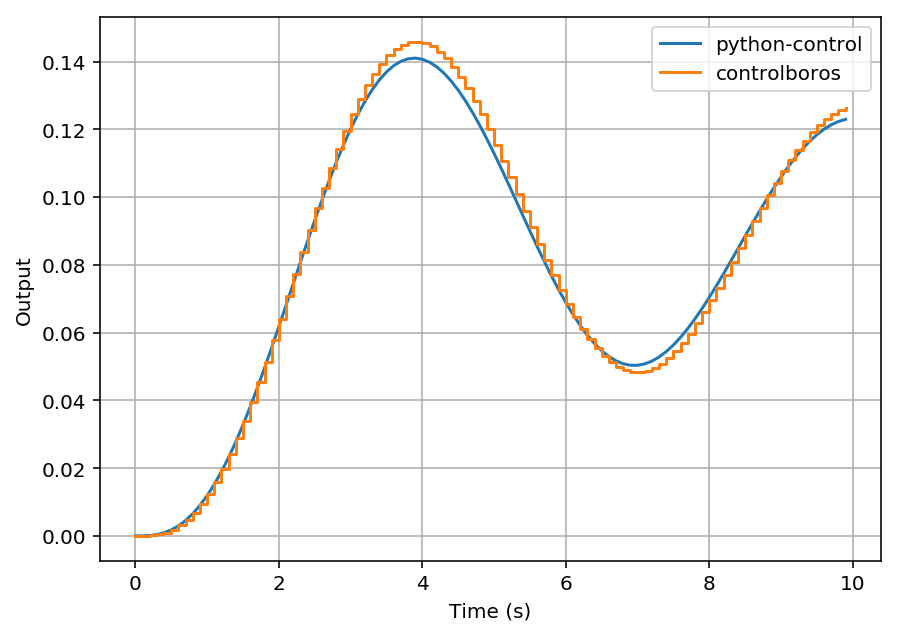

In [8]:
plt.figure(figsize=(7, 5))
plt.plot(t_ref, y_ref)
plt.step(t_cb, y_cb, where="post")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend(["python-control", "controlboros"])
plt.grid()
plt.show()

Obviously, the step response simulated with `controlboros` is very inaccurate due to 100 ms time delay in the feedback loop. We can alleviate (but never solve!) this problem by using a finer sample time, e.g. 1 ms:

In [9]:
dt_fine = 1.0e-3

a_d_ctrl, b_d_ctrl, c_d_ctrl, d_d_ctrl, _ = \
    cont2discrete((sys_ctrl.A, sys_ctrl.B, sys_ctrl.C, sys_ctrl.D), dt_fine)
a_d_plant, b_d_plant, c_d_plant, d_d_plant, _ = \
    cont2discrete((sys_plant.A, sys_plant.B, sys_plant.C, sys_plant.D), dt_fine)

ctrl_fine = controlboros.StateSpace(a_d_ctrl, b_d_ctrl, c_d_ctrl, d_d_ctrl)
plant_fine = controlboros.StateSpace(a_d_plant, b_d_plant, c_d_plant, d_d_plant)

t_cb_fine = np.arange(t_begin, t_end, dt_fine)

setpoint = np.array([1.0])  # Setpoint, constantly 1.0 because step response
command = np.array([0.0])   # Controller output
feedback = np.array([0.0])  # Feedback value

y_cb_fine = np.zeros((len(t_cb_fine),))  # Array for the step response

# Reset the inital state of the systems
ctrl_fine.set_state_to_zero()
plant_fine.set_state_to_zero()
for i in range(len(t_cb_fine)):
    command = ctrl_fine.push_stateful(setpoint - feedback)
    y_cb_fine[i] = plant_fine.push_stateful(command)
    feedback = y_cb_fine[i]

We plot the results and see that the `controlboros` solution with 1 ms step size is very close to the one computed with `python-control`:

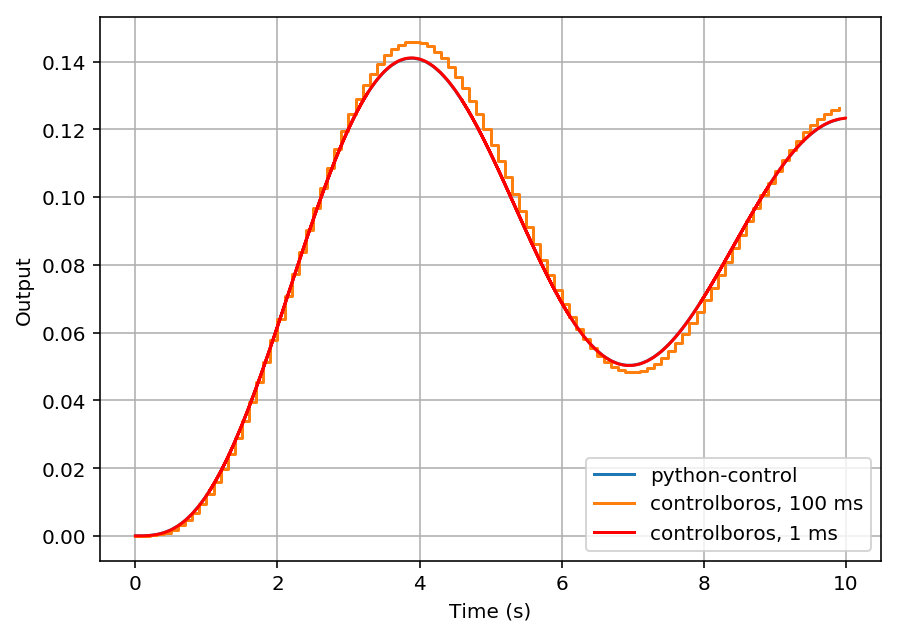

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(t_ref, y_ref)
plt.step(t_cb, y_cb, where="post")
plt.step(t_cb_fine, y_cb_fine, "r", where="post")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend(["python-control", "controlboros, 100 ms", "controlboros, 1 ms"])
plt.grid()
plt.show()